In [4]:
import numpy as np 
from linetools.spectra.xspectrum1d import XSpectrum1D
from linetools.lists.linelist import LineList
from pyigm.abssys.dla import DLASystem
from pyigm.abssys.lls import LLSSystem
from pyigm.abssys.utils import hi_model
#llist = LineList('HI')


In [5]:
#generate uniform nhi
def uniform_NHI(slls=False, mix=False, high=False):#slls，mix，high 
    """ Generate uniform log NHI

    Returns
    -------
    NHI :float 
    """
    if slls:
        NHI=np.random.uniform(19.5,20.3)
    elif high:
        NHI=np.random.uniform(21.2,22.5)
    elif mix:
        NHI=np.random.uniform(19.5,22.5)
    else:
        NHI=np.random.uniform(20.3,22.5)
    return NHI


In [6]:
#generate zabs
def init_zabs(sightline):
    """ Generate uniform zabs

    Returns
    -------
    zabs :float 
    """
    zlya = (10**sightline.loglam)/1215.67 - 1    
    gdz = (zlya < sightline.z_qso) & (10**sightline.loglam> 910.*(1+sightline.z_qso))
    zabs=np.random.choice(list(zlya[gdz]))
    return zabs

In [7]:
#generate dla
def insert_dlas(sightline,nDLA, rstate=None, slls=False,
                mix=False, high=False, noise=False,low_s2n=False, noise_boost=4.):
    """ Insert a DLA into input spectrum
    Also adjusts the noise
    Will also add noise 'everywhere' if requested
    Parameters
    ----------
    sightline
    nDLA：int
    rstate
    low_s2n : bool, optional
      Reduce the S/N everywhere.  By a factor of noise_boost
    noise_boost : float, optional
      Factor to *increase* the noise by
    noise: bool, optional
    Returns
    -------
    final_spec : XSpectrum1D  
    dlas : list
      List of DLAs inserted

    """
    #init
    if rstate is None:
        rstate = np.random.RandomState()
    #spec = XSpectrum1D.from_tuple((10**sightline.loglam,sightline.flux,sightline.sig))
    spec = XSpectrum1D.from_tuple((10**sightline.loglam,sightline.flux))#generate xspectrum1d
    # Generate DLAs
    dlas = []
    spec_dlas=[]
    for jj in range(nDLA):
        # Random z
        zabs = init_zabs(sightline)
        # Random NHI
        NHI = uniform_NHI(slls=slls, mix=mix, high=high)
        spec_dla = [(1+zabs)*1215.6701, NHI,'00'+str(jj)]
        if (slls or mix):
            dla = LLSSystem((sightline.ra,sightline.dec), zabs, None, NHI=NHI)      
        else:
            dla = DLASystem((sightline.ra,sightline.dec), zabs, None, NHI)
        dlas.append(dla)
        spec_dlas.append(spec_dla)
    # Insert
    vmodel, _ = hi_model(dlas, spec, fwhm=3.)
    #Add noise
    if noise:
        rand = rstate.randn(spec.npix)
        noise = rand * spec.sig * (1-vmodel.flux.value)
    else:
        noise=0
    # More noise??
    if low_s2n:
        rand2 = rstate.randn(spec.npix)
        more_noise = noise_boost * rand2 * spec.sig#？
        noise += more_noise
    else:
        noise_boost=1.
    #final_spec = XSpectrum1D.from_tuple((vmodel.wavelength,spec.flux.value*vmodel.flux.value+noise,noise_boost*spec.sig))more noise
    final_spec = XSpectrum1D.from_tuple((vmodel.wavelength,spec.flux.value*vmodel.flux.value))#Generate spec
    #generate new sightline
    sightline.flux=final_spec.flux.value
    sightline.dlas=spec_dlas
    
    return vmodel,final_spec, dlas


# Usage of insert_dla

In [8]:
import numpy as np
from astropy.io import fits
from dla_cnn.desi.DesiMock import DesiMock
from os.path import join
from matplotlib import pyplot as plt
import sympy
file_num = [705,706,711,718,723,731,735,743,747,748,761,773,777,785,789,791]
path = '/Users/zjq/7'
file_path = join(path,str(file_num[0]))
spectra = join(file_path,"spectra-16-%s.fits"%file_num[0])
truth = join(file_path,"truth-16-%s.fits"%file_num[0])
zbest = join(file_path,"zbest-16-%s.fits"%file_num[0])#generate file path
specs = DesiMock()
specs.read_fits_file(spectra,truth,zbest)
keys = list(specs.data.keys())
sightline = specs.get_sightline(keys[0])


In [9]:
vmodel,spec,_ =insert_dlas(sightline,nDLA=1, rstate=None, slls=False,
                mix=False, high=True, noise=False,low_s2n=False)

/Users/zjq/linetools/linetools/spectra/xspectrum1d.py:107: UserWarning: Assuming wavelength unit is Angstroms
  warnings.warn("Assuming wavelength unit is Angstroms")
/Users/zjq/pyigm/pyigm/abssys/utils.py:152: UserWarning: Generating the absorption lines from the system info, not abslines
  warnings.warn("Generating the absorption lines from the system info, not abslines")


read_sets: Using set file -- 
  /Users/zjq/linetools/linetools/lists/sets/llist_v1.3.ascii
Loading abundances from Asplund2009
Abundances are relative by number on a logarithmic scale with H=12


/Users/zjq/linetools/linetools/analysis/voigt.py:187: UserWarning: Using a sub-grid wavelength array because the input array is too coarse.
  warnings.warn('Using a sub-grid wavelength array because the input array is too coarse.')
/Users/zjq/linetools/linetools/analysis/voigt.py:188: UserWarning: Will return values rebinned to the input array.
  warnings.warn('Will return values rebinned to the input array.')
/Users/zjq/linetools/linetools/analysis/voigt.py:229: UserWarning: Rebinned tau back to your input array.  Reconsider input
  warnings.warn('Rebinned tau back to your input array.  Reconsider input')


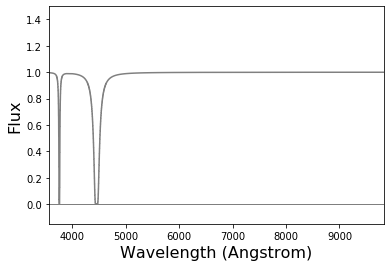

In [11]:
#plt.figure(figsize=(10,10))
vmodel.plot()

In [12]:
sightline.dlas

[[4455.40026884123, 21.663214368460313, '000']]

In [15]:
keys[0]

120129026

Text(0.5, 1.0, '120129026 with nhi=21.663,cental_wav=4455.4')

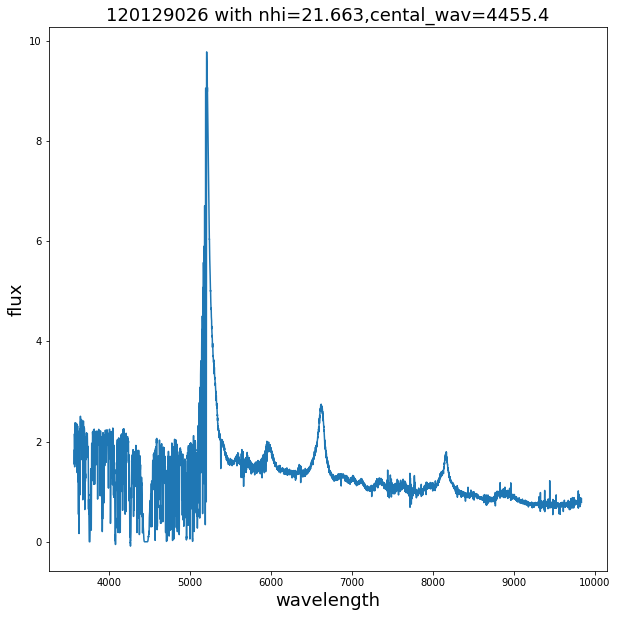

In [16]:
plt.figure(figsize=(10,10))
plt.plot(10**sightline.loglam,sightline.flux)
plt.xlabel('wavelength',fontsize=18)
plt.ylabel('flux',fontsize=18)
plt.title('120129026 with nhi=21.663,cental_wav=4455.4',fontsize=18)